# Bicycle-stations Availability Prediction

Use a supervised machine learning algorithm to predict the availability for each bicyle-sharing stations in Lyon (France) based on the history data.

I use the tree method [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) to predict a "probability" of bikes availability for each station. A number close to 1. means that you have several available bikes. A number close to 0. means you don't have many bikes.

## Some Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
import graphviz
from xgboost import plot_tree, plot_importance, to_graphviz

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

In [5]:
import folium

In [6]:
%load_ext watermark

In [7]:
%watermark -d -v -p numpy,pandas,xgboost,matplotlib,folium -g -m -w

2017-11-21 

CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
xgboost 0.6
matplotlib 2.0.2
folium 0.5.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-98-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 76a0f9c3036c61ed1a02a2940baa00aad3339725
watermark 1.5.0


The module `prediction.py` contains some functions dedicated to the bicyle-sharing stations predictions.

In [8]:
from sources.prediction import (datareader, complete_data, cleanup, bikes_probability,
                        time_resampling, prepare_data_for_training, fit, prediction)

## Read and prepare the data

In [9]:
DATAFILE = '../data/lyon.csv'

In [10]:
raw = datareader(DATAFILE)

2017-11-21 08:29:02,352 [3555] INFO     prediction: read the file '../data/lyon.csv'


In [11]:
raw.head()

,number,last_update,bike_stands,available_bike_stands,available_bikes,availabilitycode,availability,bonus,status
0,10063,2017-07-08 23:49:09,34,10,23,1,Vert,Non,OPEN
1,10021,2017-07-08 00:30:12,19,0,0,0,Gris,Non,CLOSED
2,8038,2017-07-08 23:49:26,20,6,14,1,Vert,Non,OPEN
3,7045,2017-07-08 23:52:43,20,13,7,1,Vert,Non,OPEN
4,6045,2017-07-08 23:52:14,15,7,8,1,Vert,Non,OPEN


Min and max dates of the timeseries

In [12]:
print(raw.last_update.min())
print(raw.last_update.max())

2017-07-08 00:30:12
2017-09-26 14:58:46


Clean up some columns : drop some lines with the 'CLOSED' status, drop duplicates, remove missing values, etc.

In [13]:
df_clean = cleanup(raw)

2017-11-21 08:29:12,370 [3555] INFO     prediction: cleanup processing


In [14]:
df_clean.head()

,station,ts,stands,bikes,bonus
0,10063,2017-07-08 23:49:09,10,23,Non
2,8038,2017-07-08 23:49:26,6,14,Non
3,7045,2017-07-08 23:52:43,13,7,Non
4,6045,2017-07-08 23:52:14,7,8,Non
5,7062,2017-07-08 23:57:27,5,11,Non


Pipe some processing data functions :

* time resampling to get data every 10 minutes (i.e. `10T`)
* add some columns : day of the week, hour of the day, etc.
* compute the bikes (number) "probability". It's just a normalization for each station with `num_avail_bikes / total`

In [15]:
df = (df_clean.pipe(time_resampling)
      .pipe(complete_data)
      .pipe(bikes_probability))

2017-11-21 08:29:14,987 [3555] INFO     prediction: Time resampling for each station by '10T'
2017-11-21 08:29:17,607 [3555] INFO     prediction: complete some data
2017-11-21 08:29:53,638 [3555] INFO     prediction: bikes probability


In [16]:
df.head()

,station,ts,bikes,stands,day,hour,minute,probability
0,1001,2017-07-09 00:00:00,15.0,1.0,6,0,0,0.93750
1,1001,2017-07-09 00:10:00,15.0,1.0,6,0,0,0.93750
2,1001,2017-07-09 00:20:00,14.5,1.5,6,0,10,0.90625
3,1001,2017-07-09 00:30:00,14.5,1.5,6,0,20,0.90625
4,1001,2017-07-09 00:40:00,11.5,4.5,6,0,30,0.71875


This is the final dataset. For further prediction, I could add some weather forecasts data to these features.

## Prediction

Let's select a time window (start, stop) to a single prediction.

* Two weeks of data for training
* Predict the 'probability' for the next 30 minutes and 1 hour for every station.
* Split the dataset into train and test dataset
* Compute the RMSE (Root Mean Squared Error) between the observations (i.e. probability) and the predicted values

In [17]:
start = pd.Timestamp("2017-07-11T00:00:00") # Tuesday
predict_date = pd.Timestamp("2017-07-26T10:00:00") # wednesday
# predict the next 30 minutes
freq = '30T'
# number of predictions at 'predict_date'.
# Here, the next 30 minutes and the next hour (30 minutes + 30 minutes).
# If you want to predict the next 3 hours, every 30 minutes, thus set periods=6
periods = 2

In [18]:
train_X, train_Y, test_X, test_Y = prepare_data_for_training(df,
                                                             predict_date,
                                                             freq=freq,
                                                             start=start,
                                                             periods=periods,
                                                             observation='probability')

2017-11-21 08:29:53,864 [3555] INFO     prediction: prepare data for training
2017-11-21 08:29:53,867 [3555] INFO     prediction: sort values (station, ts)
2017-11-21 08:29:54,962 [3555] INFO     prediction: compute the future availability at '30T'
2017-11-21 08:29:55,263 [3555] INFO     prediction: merge data with the future availability
2017-11-21 08:30:34,518 [3555] INFO     prediction: availability label as values
2017-11-21 08:30:34,774 [3555] INFO     prediction: cut date 2017-07-26 09:30:00
2017-11-21 08:30:34,775 [3555] INFO     prediction: stop date 2017-07-26 11:00:00
2017-11-21 08:30:34,776 [3555] INFO     prediction: split train and test according to a prediction date


In [19]:
train_X.head()

,station,bikes,stands,day,hour,minute
ts,,,,,,
2017-07-11,1001,12.0,1.0,1,0,0
2017-07-11,1002,6.0,15.5,1,0,0
2017-07-11,1003,14.0,1.0,1,0,0
2017-07-11,1005,1.0,9.0,1,0,0
2017-07-11,1006,4.5,17.5,1,0,0


In [20]:
# Observation with a shift of T+30 minutes in comparison to train_X.
# This is the 'future' availability used for traning.
train_Y.head()

ts
2017-07-11    0.923077
2017-07-11    0.295455
2017-07-11    0.933333
2017-07-11    0.100000
2017-07-11    0.227273
Name: future, dtype: float64

In [21]:
train_X.iloc[3200:3210]

,station,bikes,stands,day,hour,minute
ts,,,,,,
2017-07-11 01:30:00,7022,12.0,17.0,1,1,20
2017-07-11 01:30:00,7023,12.5,1.5,1,1,20
2017-07-11 01:30:00,7024,5.0,11.0,1,1,20
2017-07-11 01:30:00,7030,10.0,19.0,1,1,20
2017-07-11 01:30:00,7031,15.0,5.0,1,1,20
2017-07-11 01:30:00,7033,10.0,18.0,1,1,20
2017-07-11 01:30:00,7034,9.0,6.0,1,1,20
2017-07-11 01:30:00,7035,17.0,12.0,1,1,20
2017-07-11 01:30:00,7038,11.0,2.0,1,1,20


In [67]:
print(train_X.tail())
print(test_X.head())

                     station  bikes  stands  day  hour  minute
ts                                                            
2017-07-26 09:30:00    11001    8.0    10.0    2     9      20
2017-07-26 09:30:00    11002    5.0    15.0    2     9      20
2017-07-26 09:30:00    11003   11.0     9.0    2     9      20
2017-07-26 09:30:00    12001   14.0    10.0    2     9      20
2017-07-26 09:30:00    12002    2.0    17.0    2     9      20
                     station  bikes  stands  day  hour  minute
ts                                                            
2017-07-26 10:00:00     1001    2.0    14.0    2    10       0
2017-07-26 10:00:00     1002    8.0    14.0    2    10       0
2017-07-26 10:00:00     1003    2.0    13.0    2    10       0
2017-07-26 10:00:00     1005    2.0     8.0    2    10       0
2017-07-26 10:00:00     1006    2.0    19.0    2    10       0


The `fit` function create some data structure for the XGBoost from the train and test DataFrames (i.e. `xgb.DMatrix)`, configure the model and launch it with the `objective: 'reg:logistic'`. It's a regression, not a classification.

In [22]:
# the 'booster'
bst, train_prg = fit(train_X, train_Y, test_X, test_Y)

2017-11-21 08:30:35,140 [3555] INFO     prediction: fit


[0]	train-rmse:0.270776	test-rmse:0.268568
[1]	train-rmse:0.225618	test-rmse:0.223802
[2]	train-rmse:0.190967	test-rmse:0.189405
[3]	train-rmse:0.164578	test-rmse:0.163102
[4]	train-rmse:0.144765	test-rmse:0.143265
[5]	train-rmse:0.130189	test-rmse:0.128437
[6]	train-rmse:0.119687	test-rmse:0.117735
[7]	train-rmse:0.112251	test-rmse:0.110114
[8]	train-rmse:0.10707	test-rmse:0.104776
[9]	train-rmse:0.103513	test-rmse:0.101137
[10]	train-rmse:0.101105	test-rmse:0.098539
[11]	train-rmse:0.099469	test-rmse:0.096903
[12]	train-rmse:0.098367	test-rmse:0.095646
[13]	train-rmse:0.097618	test-rmse:0.094834
[14]	train-rmse:0.097077	test-rmse:0.094302
[15]	train-rmse:0.096731	test-rmse:0.093938
[16]	train-rmse:0.096451	test-rmse:0.093531
[17]	train-rmse:0.09623	test-rmse:0.093313
[18]	train-rmse:0.096052	test-rmse:0.093146
[19]	train-rmse:0.095933	test-rmse:0.093115
[20]	train-rmse:0.095802	test-rmse:0.09304
[21]	train-rmse:0.095664	test-rmse:0.092992
[22]	train-rmse:0.095555	test-rmse:0.092876
[

In [42]:
train_prg = pd.DataFrame({"train": train_prg["train"]['rmse'], "test": train_prg["test"]['rmse']})

KeyError: 'rmse'

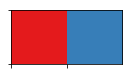

In [45]:
colors = sns.color_palette('Set1', 2)
sns.palplot(colors)

[ 0.268568  0.223802  0.189405  0.163102  0.143265  0.128437  0.117735
  0.110114  0.104776  0.101137  0.098539  0.096903  0.095646  0.094834
  0.094302  0.093938  0.093531  0.093313  0.093146  0.093115  0.09304
  0.092992  0.092876  0.092851  0.092801]
[ 0.270776  0.225618  0.190967  0.164578  0.144765  0.130189  0.119687
  0.112251  0.10707   0.103513  0.101105  0.099469  0.098367  0.097618
  0.097077  0.096731  0.096451  0.09623   0.096052  0.095933  0.095802
  0.095664  0.095555  0.095471  0.095366]


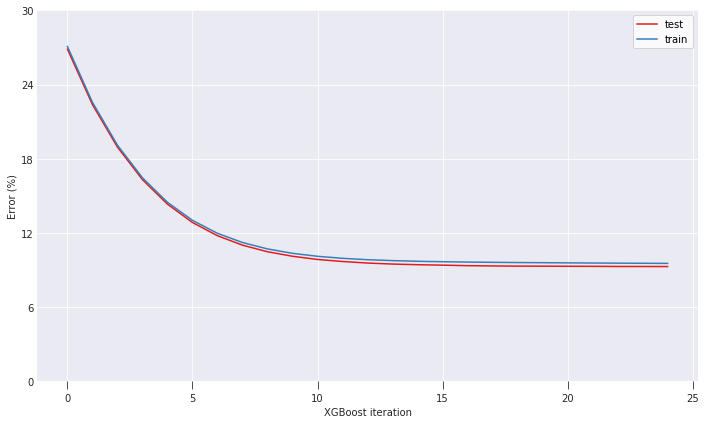

In [54]:
with sns.axes_style("darkgrid", {'xtick.major.size': 8.0}):
    fig, ax = plt.subplots(figsize=(10,6))

for k, label, color in zip(train_prg.values.T, range(2), colors):
    print(k)
    plt.plot(100*k, color=color, label=label)
    
plt.legend(train_prg.columns)
plt.xlabel('XGBoost iteration')
plt.ylabel("Error (%)")
plt.xticks(np.linspace(0, 25, 6))
plt.yticks(np.linspace(0, 30, 6))
sns.despine()
plt.tight_layout()
plt.savefig("../images/lyon_prediction_training_curves.png")

In [56]:
# compute the prediction from test_*
pred = prediction(bst, test_X, test_Y)

In [57]:
pred[:5]

array([ 0.14073603,  0.35851732,  0.14599429,  0.22701427,  0.10939126], dtype=float32)

In [58]:
print("Number of predictions: {}".format(len(pred)))

Number of predictions: 2359


In [59]:
# Compute the RMSE
rmse = np.sqrt(np.mean((pred - test_Y)**2))
rmse

0.092800839182041447

In [60]:
# must install graphviz
# plot_tree(bst)

## Store the results

In [61]:
result = test_X.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq)

result['observation'] = test_Y.copy()
result['ts_future'] = test_Y.index.shift(1, freq=freq)
result['prediction'] = pred
result['error'] = pred - test_Y
result['relative_error'] = 100. * np.abs(pred - test_Y) / test_Y
result['quad_error'] = (pred - test_Y)**2
result.to_csv("prediction-freq-{}-{}.csv".format(freq, predict_date))

In [62]:
result.head(10)

,station,bikes,stands,day,hour,minute,ts_future,observation,prediction,error,relative_error,quad_error
ts,,,,,,,,,,,,
2017-07-26 10:00:00,1001,2.0,14.0,2,10,0,2017-07-26 10:30:00,0.375000,0.140736,-0.234264,62.470392,0.054880
2017-07-26 10:00:00,1002,8.0,14.0,2,10,0,2017-07-26 10:30:00,0.255814,0.358517,0.102703,40.147679,0.010548
2017-07-26 10:00:00,1003,2.0,13.0,2,10,0,2017-07-26 10:30:00,0.133333,0.145994,0.012661,9.495718,0.000160
2017-07-26 10:00:00,1005,2.0,8.0,2,10,0,2017-07-26 10:30:00,0.300000,0.227014,-0.072986,24.328576,0.005327
2017-07-26 10:00:00,1006,2.0,19.0,2,10,0,2017-07-26 10:30:00,0.047619,0.109391,0.061772,129.721656,0.003816
2017-07-26 10:00:00,1012,16.0,4.0,2,10,0,2017-07-26 10:30:00,0.850000,0.782759,-0.067241,7.910733,0.004521
2017-07-26 10:00:00,1013,3.0,8.0,2,10,0,2017-07-26 10:30:00,0.181818,0.282898,0.101080,55.593921,0.010217
2017-07-26 10:00:00,1016,2.0,15.0,2,10,0,2017-07-26 10:30:00,0.147059,0.133801,-0.013258,9.015169,0.000176
2017-07-26 10:00:00,1020,1.0,17.0,2,10,0,2017-07-26 10:30:00,0.055556,0.079889,0.024333,43.799716,0.000592


## Some maps

CSV file with station coordinates

In [ ]:
locations = pd.read_csv("../data/lyon-stations.csv")

In [ ]:
locations.shape

Some stations were removed when the data were cleaned up. Remove them from the location data.

In [ ]:
mask = locations['idstation'].isin(result.station.unique())

In [ ]:
mask.sum()

In [ ]:
locations = locations[mask]

In [ ]:
locations = locations.rename_axis({'idstation': 'station'}, axis=1)

In [ ]:
locations.head()

Some station names contains the `'` character. Replace it by the HTML code for folium.

In [ ]:
locations["nom"] = locations['nom'].str.replace("'", "&apos;")

Select the prediction data for a specific timestamp

In [ ]:
data_to_plot = result.loc[predict_date]

In [ ]:
data_to_plot.shape

In [ ]:
data_to_plot.head()

In [ ]:
yhat = data_to_plot[['station', 'prediction']].merge(locations, on='station')
yhat.head()

In [ ]:
y = data_to_plot[['station', 'observation']].merge(locations, on='station')

In [ ]:
error = data_to_plot[['station', 'error']].merge(locations, on='station')

In [ ]:
colormap = 'RdYlBu'
cmap = plt.get_cmap(colormap)

See 

* https://matplotlib.org/examples/color/colormaps_reference.html
* https://matplotlib.org/api/colors_api.html

In [ ]:
# show the colormap use to plot the stations, values [0, 1]
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots(1)
fig.subplots_adjust(top=0.95, bottom=0.80, left=0.2, right=0.99)
ax.set_xticks([0., 64, 128, 192, 256])
ax.set_xticklabels([0., 0.25, 0.5, 0.75, 1.])
ax.set_xlabel('Bikes Availability')
ax.imshow(gradient, aspect='auto', cmap=cmap, vmin=0, vmax=1)
plt.title('Colormap used to plot stations')

* Red stations if there are 0 or a few available bikes
* Blue stations if there are several available bikes

In [ ]:
color = lambda x: mpl.colors.to_hex(cmap(x))

In [ ]:
# Lyon (France) Position
position = [45.750000, 4.850000]

In [ ]:
mp_pred = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [ ]:
# Map of the predicted values
for _,row in yhat.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['prediction']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['prediction'])
    ).add_to(mp_pred)

In [ ]:
mp_pred

In [ ]:
# Map for the observation
mp_obs = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [ ]:
# Map of the observations
for _,row in y.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color(row['observation']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color(row['observation'])
    ).add_to(mp_obs)

In [ ]:
mp_obs

In [ ]:
# Colormap for error (by default, the color map fits for [0, 1] values)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
color_error = lambda x: mpl.colors.to_hex(cmap(norm(x)))

In [ ]:
# Map for the errors
mp_error = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [ ]:
# Map of the errors
for _,row in error.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        popup=row['nom'],
        color=color_error(row['error']),
        fill=True,
        fill_opacity=0.3,
        fill_color=color_error(row['error'])
    ).add_to(mp_error)

In [ ]:
mp_error